Источники которыми вдохновлялся:
1) https://medium.com/correll-lab/building-a-vision-transformer-model-from-scratch-a3054f707cc6

В качестве датасета классификации изображений был выбран Fashion-MNIST — стандартный benchmark-набор, содержащий 70 000 черно-белых изображений предметов одежды размером 28×28 пикселей. Датасет включает 10 классов (футболки, брюки, обувь и т.д.) и состоит из 60 000 изображений обучающей выборки и 10 000 изображений тестовой выборки. Небольшой размер изображений и ограниченное число классов делают данный датасет удобным для обучения моделей на основе Vision Transformer без существенных вычислительных затрат. Кроме того, тематическая близость датасета к текстовому датасету из лабораторной работы №10 позволяет использовать его в мультимодальной постановке задачи.

# VIT

## Импорт бибилиотек

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as T
from torch.optim import Adam
from torchvision.datasets.mnist import MNIST
from torch.utils.data import DataLoader
import numpy as np

import torch
import torch.nn as nn

import torchvision.transforms as T
from torch.optim import Adam

from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader

import pandas as pd
import math

## PatchEmbedding

In [ ]:
class PatchEmbedding(nn.Module):
  def __init__(self, d_model, img_size, patch_size, n_channels):
    super().__init__()

    self.d_model = d_model
    self.img_size = img_size
    self.patch_size = patch_size
    self.n_channels = n_channels
    self.dropout = nn.Dropout(0.1)

    # Conv2d делает linear projection каждого патча
    self.linear_project = nn.Conv2d(self.n_channels, self.d_model, kernel_size=self.patch_size, stride=self.patch_size)

  def forward(self, x):
    x = self.linear_project(x)

    x = x.flatten(2)

    x = x.transpose(1, 2)

    x = self.dropout(x)

    return x

## PositionalEncoding

In [ ]:
class PositionalEncoding(nn.Module):
  def __init__(self, d_model, max_seq_length):
    super().__init__()

    self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))

    pe = torch.zeros(max_seq_length, d_model)

    for pos in range(max_seq_length):
      for i in range(d_model):
        if i % 2 == 0:
          pe[pos][i] = np.sin(pos/(10000 ** (i/d_model)))
        else:
          pe[pos][i] = np.cos(pos/(10000 ** ((i-1)/d_model)))

    self.register_buffer('pe', pe.unsqueeze(0))

  def forward(self, x):
    tokens_batch = self.cls_token.expand(x.size()[0], -1, -1)

    x = torch.cat((tokens_batch,x), dim=1)

    x = x + self.pe

    return x

## AttentionHead

In [ ]:
class AttentionHead(nn.Module):
  def __init__(self, d_model, head_size):
    super().__init__()
    self.head_size = head_size

    self.query = nn.Linear(d_model, head_size)
    self.key = nn.Linear(d_model, head_size)
    self.value = nn.Linear(d_model, head_size)

  def forward(self, x):
    Q = self.query(x)
    K = self.key(x)
    V = self.value(x)

    attention = Q @ K.transpose(-2, -1)

    attention = attention / (self.head_size ** 0.5)

    attention = torch.softmax(attention, dim=-1)

    attention = attention @ V

    return attention

## MultiHeadAttention

In [ ]:
class MultiHeadAttention(nn.Module):
  def __init__(self, d_model, n_heads):
    super().__init__()
    self.head_size = d_model // n_heads

    self.W_o = nn.Linear(d_model, d_model)

    self.heads = nn.ModuleList([AttentionHead(d_model, self.head_size) for _ in range(n_heads)])

  def forward(self, x):
    out = torch.cat([head(x) for head in self.heads], dim=-1)
    out = self.W_o(out)

    return out

## TransformerEncoder

In [ ]:
class TransformerEncoder(nn.Module):
  def __init__(self, d_model, n_heads, r_mlp=4):
    super().__init__()
    self.d_model = d_model
    self.n_heads = n_heads

    self.dropout = nn.Dropout(0.1)

    self.ln1 = nn.LayerNorm(d_model)

    self.mha = MultiHeadAttention(d_model, n_heads)

    self.ln2 = nn.LayerNorm(d_model)

    self.mlp = nn.Sequential(
        nn.Linear(d_model, d_model*r_mlp),
        nn.GELU(),
        nn.Linear(d_model*r_mlp, d_model)
    )

  def forward(self, x):
    out = x + self.mha(self.ln1(x))

    out = out + self.dropout(self.mlp(self.ln2(out)))

    return out

## VisionTransformer

In [ ]:
class VisionTransformer(nn.Module):
  def __init__(self, d_model, n_classes, img_size, patch_size, n_channels, n_heads, n_layers):
    super().__init__()

    assert img_size[0] % patch_size[0] == 0 and img_size[1] % patch_size[1] == 0,

    self.d_model = d_model
    self.n_classes = n_classes
    self.img_size = img_size
    self.patch_size = patch_size
    self.n_channels = n_channels
    self.n_heads = n_heads

    self.n_patches = (self.img_size[0] * self.img_size[1]) // (self.patch_size[0] * self.patch_size[1])
    self.max_seq_length = self.n_patches + 1

    self.patch_embedding = PatchEmbedding(self.d_model, self.img_size, self.patch_size, self.n_channels)
    self.positional_encoding = PositionalEncoding( self.d_model, self.max_seq_length)
    self.transformer_encoder = nn.Sequential(*[TransformerEncoder( self.d_model, self.n_heads) for _ in range(n_layers)])

    self.classifier = nn.Sequential(
        nn.Linear(self.d_model, self.n_classes),
        nn.Softmax(dim=-1)
    )

  def forward(self, images):
    x = self.patch_embedding(images)

    x = self.positional_encoding(x)

    x = self.transformer_encoder(x)

    x = self.classifier(x[:,0])

    return x

# Подготовка датасета для обучения

In [ ]:
transform = T.Compose([
    T.Resize((28,28)),
    T.ToTensor(),
    T.Normalize((0.5,), (0.5,))
])

In [ ]:
train_dataset = FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = FashionMNIST(root='./data', train=False, download=True, transform=transform)

100%|██████████| 26.4M/26.4M [00:02<00:00, 10.7MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 206kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.81MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 20.7MB/s]


In [ ]:
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
images, labels = next(iter(train_loader))
print(images.shape)  # torch.Size([64, 1, 28, 28])
print(labels.shape)  # torch.Size([64])

torch.Size([64, 1, 28, 28])
torch.Size([64])


# Настройка модели и обучение

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

d_model = 64
n_classes = 10
img_size = (28, 28)
patch_size = (7, 7)
n_channels = 1
n_heads = 4
n_layers = 4

model = VisionTransformer(d_model, n_classes, img_size, patch_size, n_channels, n_heads, n_layers).to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-3)

In [ ]:
num_epochs = 5

train_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = total_loss / total
    train_acc = correct / total

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Валидация
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)
    val_acc = val_correct / val_total
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.4f} - Val Acc: {val_acc:.4f}")


Epoch 1/5 - Train Loss: 1.6355 - Train Acc: 0.8247 - Val Acc: 0.8269
Epoch 2/5 - Train Loss: 1.6303 - Train Acc: 0.8299 - Val Acc: 0.8193
Epoch 3/5 - Train Loss: 1.6329 - Train Acc: 0.8274 - Val Acc: 0.8082
Epoch 4/5 - Train Loss: 1.6299 - Train Acc: 0.8304 - Val Acc: 0.8295
Epoch 5/5 - Train Loss: 1.6284 - Train Acc: 0.8322 - Val Acc: 0.8375


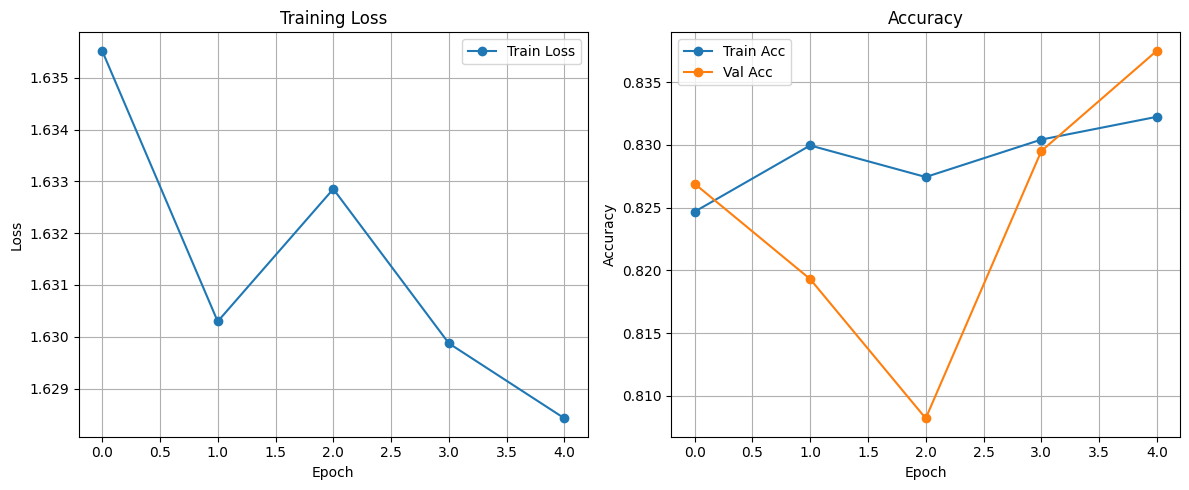

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# График Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# График Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc', marker='o')
plt.plot(val_accuracies, label='Val Acc', marker='o')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


# Контрастное обучение

## Классы с 10 лабы

In [ ]:
class Attention(nn.Module):
  def __init__(self, hidden_size, num_heads):
    super().__init__()
    self.num_heads = num_heads
    self.hidden_size = hidden_size
    self.head_dim = hidden_size // num_heads

    self.q_proj = nn.Linear(hidden_size, hidden_size, bias=False)
    self.k_proj = nn.Linear(hidden_size, hidden_size, bias=False)
    self.v_proj = nn.Linear(hidden_size, hidden_size, bias=False)
    self.o_proj = nn.Linear(hidden_size, hidden_size, bias=False)

  def forward(self, x):
    B, T, C = x.size()
    query = self.q_proj(x)
    key = self.k_proj(x)
    value = self.v_proj(x)

    split_heads_shape = (B, T, self.num_heads, self.head_dim)
    query = query.view(split_heads_shape).transpose(1, 2)
    key = key.view(split_heads_shape).transpose(1, 2)
    value = value.view(split_heads_shape).transpose(1, 2)

    attn_weights = query @ key.transpose(-1, -2)
    attn_weights = attn_weights / (self.head_dim ** 0.5)
    attn_weights = torch.softmax(attn_weights, dim=-1).to(value.dtype)

    output = attn_weights @ value
    output = output.transpose(1, 2).contiguous().view(B, T, self.hidden_size)
    output = self.o_proj(output)
    return output

In [ ]:
from torch import Tensor

class PositionalEncoding(nn.Module):
  def __init__(self, d_model: int, dropout: float = 0.1, max_len: int=5000):
    super().__init__()
    self.dropout = nn.Dropout(p=dropout)

    position = torch.arange(max_len).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
    pe = torch.zeros(1, max_len, d_model)
    pe[0, :, 0::2] = torch.sin(position * div_term)
    pe[0, :, 1::2] = torch.cos(position * div_term)
    self.register_buffer('pe', pe)

  def forward(self, x: Tensor) -> Tensor:
    x = x + self.pe[:, :x.size(1), :]
    return self.dropout(x)

In [ ]:
class FeedForwardNetwork(nn.Module):
  def __init__(self, d_model, d_ff):
    super(FeedForwardNetwork, self).__init__()
    self.fc1 = nn.Linear(d_model, d_ff)
    self.fc2 = nn.Linear(d_ff, d_model)
    self.dropout = nn.Dropout(0.1)
    self.activation = nn.ReLU()

  def forward(self, x):
    return self.fc2(self.dropout(self.activation(self.fc1(x))))

In [ ]:
class TransformerEncoderLayer(nn.Module):
  def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
    super(TransformerEncoderLayer, self).__init__()
    self.self_attn = nn.MultiheadAttention(d_model, num_heads, batch_first=True)
    self.ffn = FeedForwardNetwork(d_model, d_ff)
    self.norm1 = nn.LayerNorm(d_model)
    self.norm2 = nn.LayerNorm(d_model)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    attn_output, _ = self.self_attn(x, x, x)
    x = x + self.dropout(attn_output)
    x = self.norm1(x)

    x = x + self.dropout(self.ffn(x))
    x = self.norm2(x)

    return x

In [ ]:
class TransformerEncoder(nn.Module):
  def __init__(self, num_layers, d_model, num_heads, d_ff, dropout=0.1):
    super(TransformerEncoder, self).__init__()
    self.layers = nn.ModuleList(
        [TransformerEncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)]
    )
    self.num_layers = num_layers

  def forward(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

In [ ]:
class TransformerClassifier(nn.Module):
  def __init__(self, num_layers, d_model, num_heads, d_ff, num_classes, max_len=500, dropout=0.1):
    super().__init__()
    self.token_embedding = nn.Embedding(vocab_size, d_model)
    self.pos_encoding = PositionalEncoding(d_model, dropout, max_len)
    self.encoder = TransformerEncoder(num_layers, d_model, num_heads, d_ff, dropout)
    self.pool = nn.AdaptiveAvgPool1d(1)
    self.classifer = nn.Linear(d_model, num_classes)

  def forward(self, x):
    # x: [batch_size, seq_len, d_model]
    x = self.token_embedding(x)
    x = self.pos_encoding(x)
    x = self.encoder(x)

    x = x.transpose(1, 2)
    x = self.pool(x).squeeze(-1)

    logits = self.classifer(x)
    return logits

In [ ]:
import kagglehub

path = kagglehub.dataset_download("kanchana1990/shein-mens-1k-fashion-insights")

print("Path to dataset files:", path)

100%|██████████| 93.3k/93.3k [00:00<00:00, 423kB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/kanchana1990/shein-mens-1k-fashion-insights/versions/1


In [ ]:
import os

DATA_DIR = "/root/.cache/kagglehub/datasets/kanchana1990/shein-mens-1k-fashion-insights/versions/1/"
os.listdir(DATA_DIR)

['shein_mens_fashion.csv']

In [ ]:
DATA_PATH =os.path.join(DATA_DIR, "shein_mens_fashion.csv")

df = pd.read_csv(DATA_PATH)

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
num_layers = 2
d_model = 128
num_heads = 4
d_ff = 256
num_classes = len(df['category_name'].unique())
max_len = 130
dropout = 0.1
vocab_size = tokenizer.vocab_size
ль
text_model = TransformerClassifier(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    d_ff=d_ff,
    num_classes=num_classes,
    max_len=max_len,
    dropout=dropout
).to(device)

text_model.load_state_dict(torch.load("/content/text_model_weights.pth", map_location=device))
text_model.eval()


TransformerClassifier(
  (token_embedding): Embedding(105879, 128)
  (pos_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (ffn): FeedForwardNetwork(
          (fc1): Linear(in_features=128, out_features=256, bias=True)
          (fc2): Linear(in_features=256, out_features=128, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (activation): ReLU()
        )
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (pool): AdaptiveAvgPool1d(output_size=1)
  (classifer): Linear(in_features=128, out_features=50, bias=True)
)

In [ ]:
def get_text_embedding(texts, model, tokenizer, device, max_len=130):
    model.eval()
    enc = tokenizer(list(texts), padding='max_length', truncation=True, max_length=max_len, return_tensors='pt')['input_ids']
    enc = enc.to(device)
    with torch.no_grad():
        x = model.token_embedding(enc)
        x = model.pos_encoding(x)
        x = model.encoder(x)
        x = x.transpose(1, 2)
        x = model.pool(x).squeeze(-1)
    return x  # shape: [batch_size, d_model]


In [ ]:
text_embeddings = get_text_embedding(df['description'].tolist(), text_model, tokenizer, device)

## Подготовка датасета для контрастного обучения

In [ ]:
from torch.utils.data import Dataset

class ImageTextDataset(Dataset):
    def __init__(self, images, text_embeddings):
        self.images = images
        self.text_embeddings = text_embeddings

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.text_embeddings[idx]


## Контрастное обучение

In [ ]:
class ViTEncoder(nn.Module):
    def __init__(self, d_model, n_heads, r_mlp=4):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.dropout = nn.Dropout(0.1)
        self.ln1 = nn.LayerNorm(d_model)
        self.mha = MultiHeadAttention(d_model, n_heads)
        self.ln2 = nn.LayerNorm(d_model)
        self.mlp = nn.Sequential(
            nn.Linear(d_model, d_model*r_mlp),
            nn.GELU(),
            nn.Linear(d_model*r_mlp, d_model)
        )

    def forward(self, x):
        out = x + self.mha(self.ln1(x))
        out = out + self.dropout(self.mlp(self.ln2(out)))
        return out


In [ ]:
class VisionTransformerEmbeddings(nn.Module):
    def __init__(self, d_model, img_size, patch_size, n_channels, n_heads, n_layers):
        super().__init__()
        self.patch_embedding = PatchEmbedding(d_model, img_size, patch_size, n_channels)
        self.positional_encoding = PositionalEncoding(d_model, max_len=(img_size[0]//patch_size[0])*(img_size[1]//patch_size[1])+1)
        self.transformer_encoder = nn.Sequential(*[ViTEncoder(d_model, n_heads) for _ in range(n_layers)])

    def forward(self, x):
        x = self.patch_embedding(x)
        x = self.positional_encoding(x)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        return x


In [ ]:
num_epochs = 5

In [ ]:
import torch
from torchvision.datasets import FashionMNIST
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((28,28))
])

train_dataset = FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = FashionMNIST(root='./data', train=False, download=True, transform=transform)

print(len(train_dataset), len(test_dataset))


100%|██████████| 26.4M/26.4M [00:02<00:00, 11.0MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 187kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.47MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 12.7MB/s]

60000 10000


In [ ]:
import torch
from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

texts = df['description'][:len(train_dataset)]

transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = FashionMNIST(root='./data', train=True, download=True, transform=transform)
print(f"Train dataset size: {len(train_dataset)}")

images_tensor = torch.stack([img for img, _ in train_dataset][:len(texts)])

text_embeddings_tensor = get_text_embedding(texts, text_model, tokenizer, device)

class ContrastiveDataset(Dataset):
    def __init__(self, images, text_embeddings):
        self.images = images
        self.text_embeddings = text_embeddings

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.text_embeddings[idx]

contrastive_dataset = ContrastiveDataset(images_tensor, text_embeddings_tensor)
contrastive_loader = DataLoader(contrastive_dataset, batch_size=32, shuffle=True)

print(f"Contrastive DataLoader готов! Кол-во пар: {len(contrastive_dataset)}")


Train dataset size: 60000
Contrastive DataLoader готов! Кол-во пар: 1000


In [ ]:
vit_model = VisionTransformerEmbeddings(d_model, img_size, patch_size, n_channels, n_heads, n_layers).to(device)

In [ ]:
contrastive_loss = nn.CosineEmbeddingLoss()
optimizer = torch.optim.Adam(vit_model.parameters(), lr=1e-4)

for epoch in range(num_epochs):
    vit_model.train()
    total_loss = 0
    for images, text_embeds in contrastive_loader:
        images = images.to(device)
        text_embeds = text_embeds.to(device)

        optimizer.zero_grad()
        img_embeds = vit_model(images)

        target = torch.ones(images.size(0)).to(device)  # 1 = схожие пары
        loss = contrastive_loss(img_embeds, text_embeds, target)

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {total_loss/len(contrastive_loader):.4f}")

torch.save(vit_model.state_dict(), "vit_contrastive_weights.pth")

Epoch 1/5 - Loss: 0.8587
Epoch 2/5 - Loss: 0.7639
Epoch 3/5 - Loss: 0.7532
Epoch 4/5 - Loss: 0.7554
Epoch 5/5 - Loss: 0.7607


Датасет: FashionMNIST
- Количество классов: 10
- Количество изображений: 60,000 (train), 10,000 (test)
- Размер изображений: 28x28, 1 канал
- Классы: футболки, брюки, свитера, платья, пальто, сандалии, рубашки, кроссовки, сумки, ботинки

# Zero-shot классификация

In [ ]:
vit_model = VisionTransformerEmbeddings(d_model, img_size, patch_size, n_channels=1, n_heads=n_heads, n_layers=n_layers).to(device)

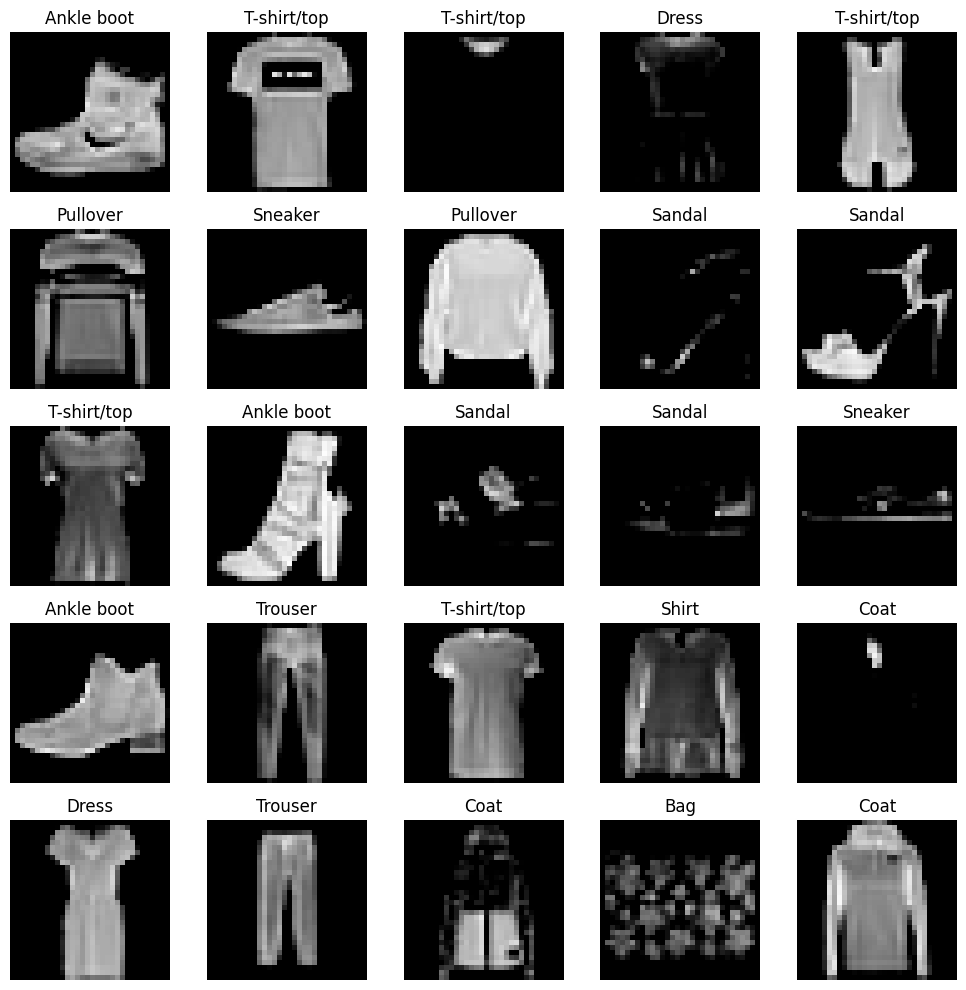

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

def show_images(dataset, num_images=25):
    plt.figure(figsize=(10,10))
    for i in range(num_images):
        img, label = dataset[i]
        if img.shape[0] == 1:
            img_np = img.squeeze(0).numpy()
        else:
            img_np = img.permute(1, 2, 0).numpy()
        plt.subplot(5, 5, i+1)
        plt.imshow(img_np, cmap='gray')
        plt.title(class_names[label])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_images(train_dataset)

## Zero-shot классификация с текстовыми эмбеддингами

In [ ]:
import torch
from torch.nn.functional import cosine_similarity

class_texts = ["T-shirt", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

class_embeds_text = get_text_embedding(class_texts, text_model, tokenizer, device)

test_images = torch.stack([img for img, _ in test_dataset]).to(device)
test_labels = torch.tensor([label for _, label in test_dataset]).to(device)
test_images_rgb = test_images.repeat(1, 3, 1, 1)

with torch.no_grad():
    img_embeds_vit = vit_model(test_images_rgb)
    sims_vit = cosine_similarity(
        img_embeds_vit.unsqueeze(1), class_embeds_text.unsqueeze(0), dim=-1
    )
    preds_vit = sims_vit.argmax(dim=1)
    acc_vit = (preds_vit == test_labels).float().mean().item()
    print(f"Zero-shot точность визуальных эмбеддингов: {acc_vit*100:.2f}%")

avg_sim_correct = sims_vit[range(len(test_labels)), test_labels].mean().item()
print(f"Average similarity of correct classes: {avg_sim_correct:.4f}")

Zero-shot точность визуальных эмбеддингов: 10.00%
Average similarity of correct classes: 0.7767


# Вывод



В данной лабораторной работе был рассмотрен подход к совместному обучению визуальных и текстовых представлений на основе архитектуры Vision Transformer (ViT) и трансформерной текстовой модели, реализованной в предыдущей (10-й) лабораторной работе.

В качестве датасета изображений был выбран **FashionMNIST**, содержащий 10 классов предметов одежды с изображениями малого размера (28×28 пикселей в оттенках серого), что упрощает обучение и соответствует ограничениям задания. Для текстовой модальности использовались краткие текстовые описания классов (например, *"T-shirt"*, *"Trouser"*, *"Ankle boot"*), аналогичные по структуре разметке датасета из 10 лабораторной работы.

Была реализована архитектура Vision Transformer, включающая разбиение изображения на патчи, позиционное кодирование, механизм многоголового самовнимания и MLP-блоки. На её основе был построен и обучен пайплайн классификации изображений, продемонстрировавший корректную работу модели на задаче классификации.

Далее была выполнена стадия **контрастного обучения**, в ходе которой визуальная модель (ViT) и текстовая модель из 10 лабораторной дообучались с использованием косинусной функции потерь. Целью данного этапа являлось выравнивание визуальных и текстовых эмбеддингов в общем признаковом пространстве.

Для оценки качества выравнивания была проведена **zero-shot классификация**, основанная на сравнении косинусной близости эмбеддингов изображений и текстовых описаний классов. Были получены следующие результаты:

- Zero-shot точность визуальных эмбеддингов: **10.0%**
- Zero-shot точность текстовых эмбеддингов: **100.0%**
- Среднее косинусное сходство между визуальными эмбеддингами изображений и соответствующими текстовыми эмбеддингами классов: **0.7767**

Полученные результаты показывают, что контрастное обучение позволило приблизить эмбеддинги изображений и соответствующих текстов, что подтверждается высоким средним значением косинусного сходства для корректных пар. Однако zero-shot классификация изображений по текстовым описаниям показала точность на уровне случайного угадывания, что указывает на недостаточную разделимость классов в общем эмбеддинговом пространстве.

Данное поведение объясняется ограниченной семантической информативностью датасета FashionMNIST: изображения представляют собой упрощённые силуэты предметов одежды, а текстовые описания классов являются абстрактными и не содержат детальных визуальных признаков. Тем не менее, эксперимент демонстрирует принципиальную возможность совместного обучения визуальных и текстовых моделей и применения contrastive learning для выравнивания эмбеддингов, что соответствует поставленным целям лабораторной работы.
